# Fe3+/Fe2+ model errors

In [63]:
import pandas as pd
import numpy as np
from scipy import optimize as opt
from scipy.interpolate import splrep, splev
from IPython.display import clear_output

import MagmaPandas as mp
import MagmaPandas.Fe_redox.models as fe
from MagmaPandas.model_errors import _error_func, _running_stddev

import matplotlib.pyplot as plt

In [2]:
slags = ["KC1989", "K2000", "HI2007"]
hydrous = ["G2002", "G2003", "Bc2005"]
simplified_compositions = ["M2006"]#"BM2010"

exclude = slags + simplified_compositions

data = pd.read_csv("../../../src/MagmaPandas/Fe_redox/data/Fe3Fe2_validation_data.csv")
data = data.replace([np.inf, -np.inf], np.nan)
data = data.query("ref not in @exclude")
data.head(), data.shape

(     ref    run   SiO2  TiO2  Al2O3   MgO   CaO  Na2O   K2O  P2O5  MnO  CoO  \
 0  A2019  S6928  59.10  2.78  15.27  2.21  7.23  3.99  0.79   0.0  NaN  NaN   
 1  A2019  S6889  57.68  2.39  14.46  2.04  7.08  4.61  0.78   0.0  NaN  NaN   
 2  A2019  S6879  58.20  2.22  14.81  2.09  7.19  4.61  0.80   0.0  NaN  NaN   
 3  A2019  S6820  58.19  2.37  14.57  2.05  7.12  4.57  0.77   0.0  NaN  NaN   
 4  A2019  S6811  59.06  2.80  14.57  2.56  7.27  4.49  0.82   0.0  NaN  NaN   
 
    NiO  Pb       FeO      T_K         fO2   _Fe3Fe2  P_bar  dataset  
 0  NaN NaN  8.665173  1673.15    3.467167  1.200670  40000        1  
 1  NaN NaN  8.359237  2023.15  252.635385  0.845696  60000        1  
 2  NaN NaN  6.865552  2173.15  617.838140  1.606266  60000        1  
 3  NaN NaN  8.224266  2023.15  252.635385  0.874943  60000        1  
 4  NaN NaN  7.342452  2173.15  617.838140  2.058738  60000        1  ,
 (888, 20))

In [3]:
models = [
    "borisov",
    "kressCarmichael",
    "jayasuriya",
    "putirka2016_6b",
    "putirka2016_6c",
    "Deng2020",
    "Oneill2006",
    "Oneill2018",
    "Armstrong2019",
    "Zhang2017",
    "Hirschmann2022",
    "Sun2024"
]

results = {}

In [4]:
T_K = data["T_K"]
P_bar = data["P_bar"]
fO2 = data["fO2"]

melts = mp.Melt(data, units="wt. %", datatype="oxide")
melts = melts[melts.elements]
melts.recalculate(inplace=True)

In [5]:
for i, m in enumerate(models):

    model = getattr(fe, m)

    clear_output()
    print(f"model: {m}\n{i+1:03}/{len(models):03}")

    Fe3Fe2 = data[["ref", "run", "P_bar", "T_K", "fO2", "_Fe3Fe2",]].copy()
    Fe3Fe2["_Fe3Fe2_model"] = model.calculate_Fe3Fe2(melt_mol_fractions=melts.moles, P_bar=P_bar, T_K=T_K, fO2=fO2)
    Fe3Fe2["delta"] = Fe3Fe2["_Fe3Fe2_model"] -Fe3Fe2["_Fe3Fe2"]
    Fe3Fe2 = Fe3Fe2.sort_values("_Fe3Fe2")

    results[m] = Fe3Fe2

    

model: Sun2024
012/012


In [6]:
for m in models:

    na = sum(results[m]["_Fe3Fe2_model"].isna())
    print(f"{m}: {na}")


borisov: 0
kressCarmichael: 0
jayasuriya: 0
putirka2016_6b: 0
putirka2016_6c: 0
Deng2020: 0
Oneill2006: 0
Oneill2018: 0
Armstrong2019: 0
Zhang2017: 0
Hirschmann2022: 0
Sun2024: 0


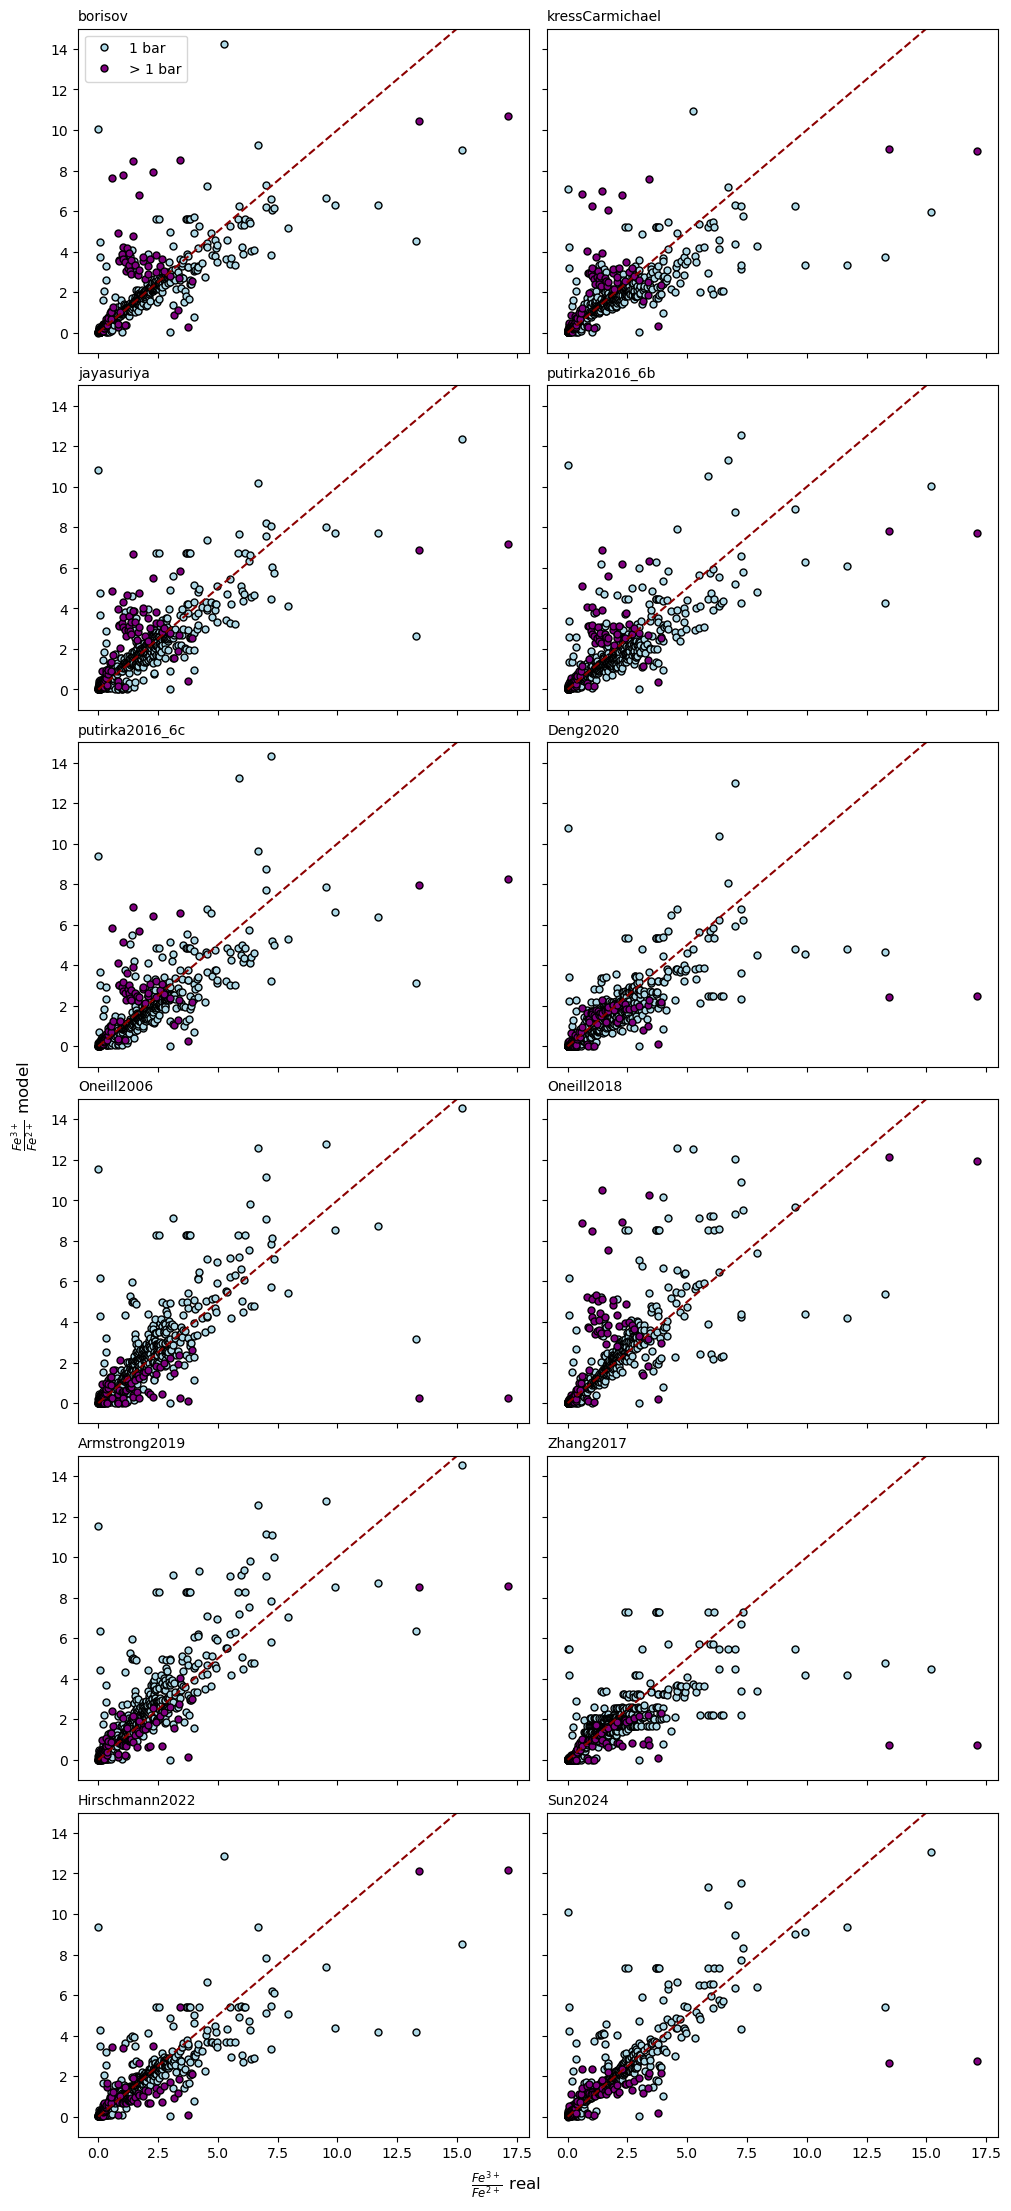

In [7]:
qry = ""
pressure_cutoff = 1

fig, axs = plt.subplots(6, 2, figsize=(10,22), sharex=True, sharey=True, constrained_layout=True)

x_max = data["_Fe3Fe2"].max()

for i, (name, d) in enumerate(results.items()):

    d_lp = d.query("(P_bar <= @pressure_cutoff) & (_Fe3Fe2 < 20)")
    d_hp = d.query("(P_bar > @pressure_cutoff) & (_Fe3Fe2 < 20)")

    for df, c, l in zip((d_lp, d_hp), ("lightblue", "purple"), ("1 bar", "> 1 bar")):  
    
        axs[i // 2, i % 2].plot(df["_Fe3Fe2"] , df["_Fe3Fe2_model"] , "o", mec="k", markersize=5, c=c, label=l)
        
    axs[i // 2, i % 2].plot([0, 15], [0, 15], "--", c="darkred", linewidth=1.5)
    axs[i // 2, i % 2].set_title(name, loc="left", size=10)


axs[0, 0].set_ylim(-1,15)
axs[0,0].legend()


fig.supxlabel("$\\frac{Fe^{3+}}{Fe^{2+}}$ real")
fig.supylabel("$\\frac{Fe^{3+}}{Fe^{2+}}$ model")
plt.show()




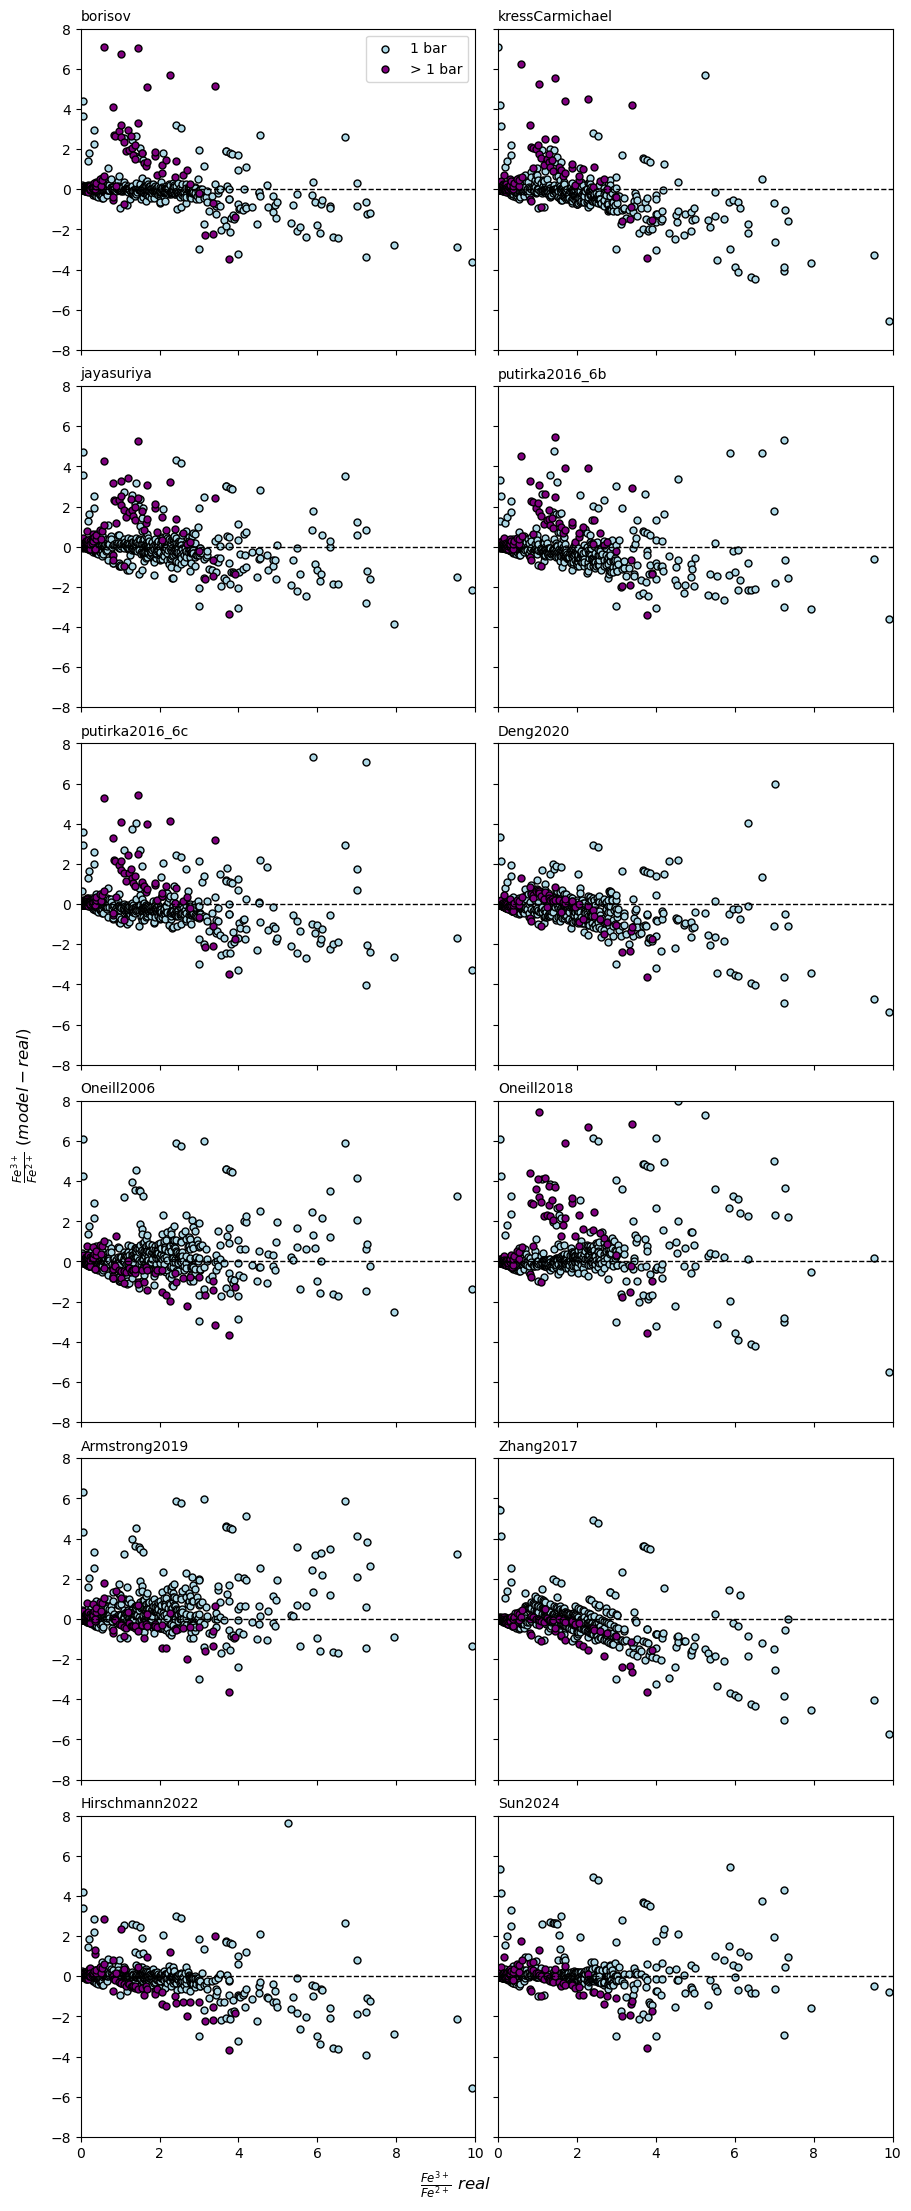

In [8]:
fig, axs = plt.subplots(6, 2, figsize=(9,22), sharey=True, sharex=True, constrained_layout=True)

for i, (name, d) in enumerate(results.items()):
    
    d_lp = d.query("P_bar <= @pressure_cutoff")
    d_hp = d.query("P_bar > @pressure_cutoff")


    for df, c, l in zip((d_lp, d_hp), ("lightblue", "purple"), ("1 bar", "> 1 bar")):        

        axs[i // 2, i % 2].scatter(df["_Fe3Fe2"], df["delta"], marker="o", ec="k", c=c, s=5**2, label=l)

    axs[i // 2, i % 2].axhline(y=0, linestyle="--", linewidth=1., c="k")
    axs[i // 2, i % 2].set_title(name, loc="left", size=10)    


axs[0,0].set_ylim(-8, 8)
axs[0,0].set_xlim(0, 10)
axs[0,0].legend()


fig.supylabel("$\\frac{Fe^{3+}}{Fe^{2+}}\ (model - real)$")
fig.supxlabel("$\\frac{Fe^{3+}}{Fe^{2+}}\ real$")

plt.show()



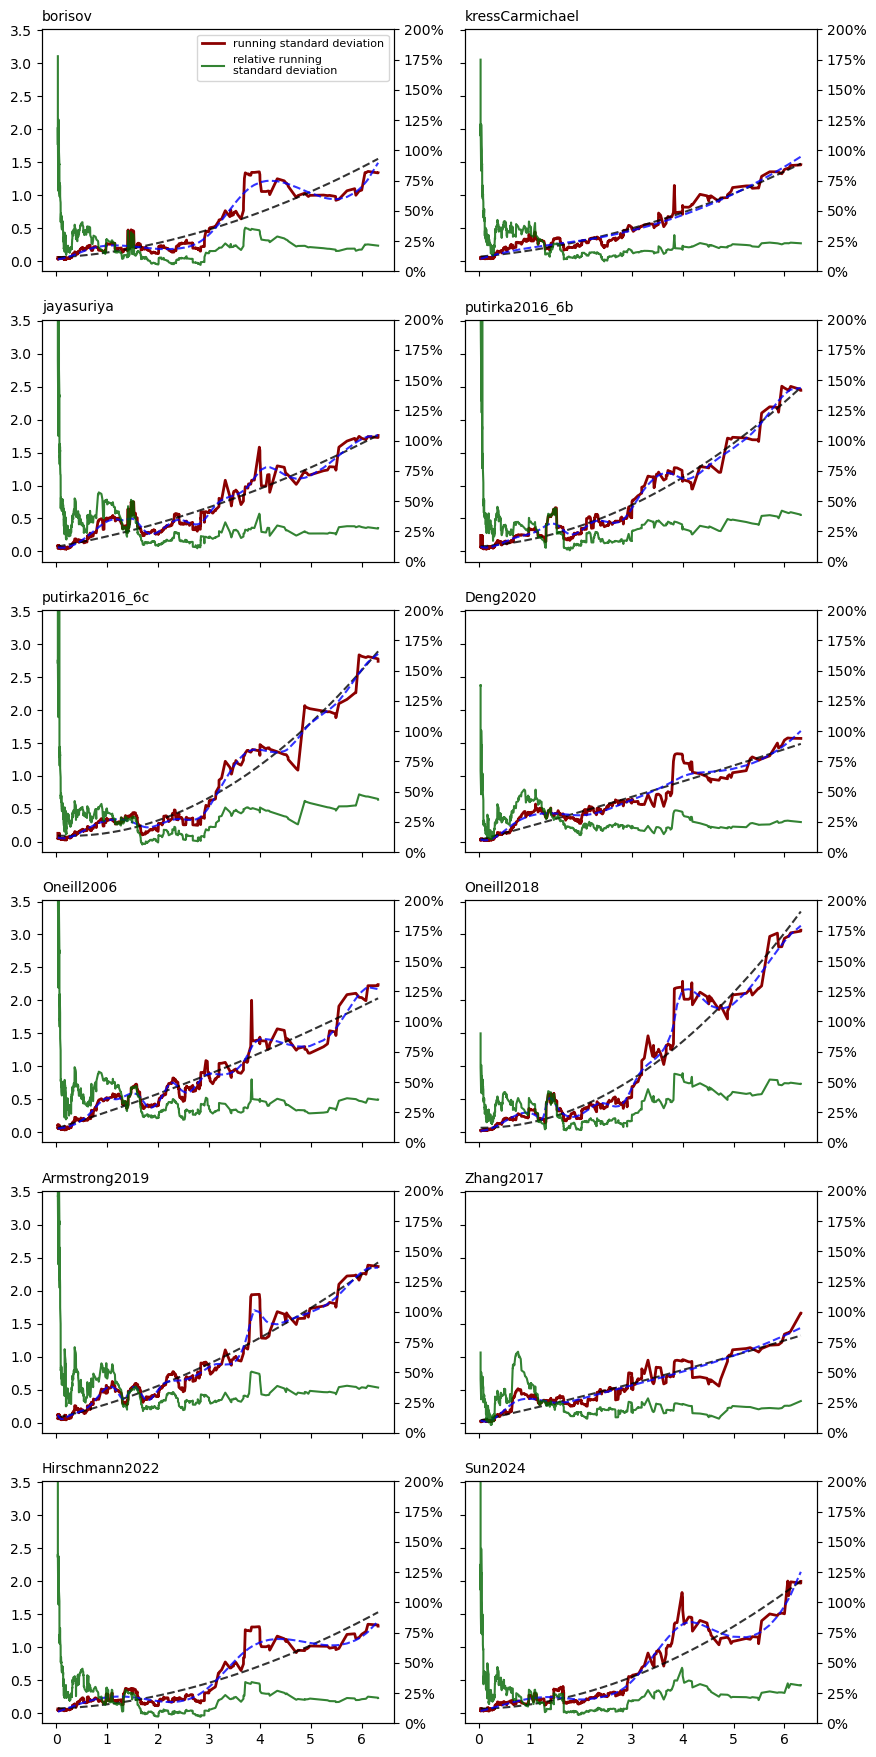

In [93]:
error_params = {}


from matplotlib.ticker import FuncFormatter

pressure_cutoff = 1

fig, axs = plt.subplots(6, 2, figsize=(10,22), sharey=True, sharex=True)

sec_axs = np.empty(shape=axs.shape, dtype=axs.dtype)

for i, (name, d) in enumerate(results.items()):
    
    d_lp = d.query("P_bar <= @pressure_cutoff & (_Fe3Fe2 < 20)").sort_values("_Fe3Fe2")

    idx = d_lp["_Fe3Fe2_model"].dropna().index
    xvals, stddev = _running_stddev(d_lp.loc[idx, "_Fe3Fe2"], d_lp.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    f_results = opt.curve_fit(f=_error_func, xdata=xvals, ydata=stddev, method="lm")
    error_params[name] = f_results[0]

    params = splrep(xvals, stddev, s=3)
    
    # axs[i // 2, i % 2].plot(d.query(qry)["_Fe3Fe2"] , d.query(qry)["_Fe3Fe2_model"] , "o", mec="k", markersize=3)
    axs[i // 2, i % 2].plot(xvals, stddev, "-", color="darkred", linewidth=2, label="running standard deviation")
    axs[i // 2, i % 2].plot(xvals, _error_func(xvals, *error_params[name]), "--", color="k", linewidth=1.5, alpha=0.8)
    
    axs[i // 2, i % 2].plot(xvals, splev(xvals, params), "--", color="blue", linewidth=1.5, alpha=0.8)


    sec_axs[i // 2, i % 2] = axs[i // 2, i % 2].twinx()
    sec_axs[i // 2, i % 2].sharey(sec_axs[0, 0])
    sec_axs[i // 2, i % 2].plot(xvals, stddev / xvals, "-", color="darkgreen", linewidth=1.5, alpha=0.8, label="relative running\nstandard deviation")

    axs[i // 2, i % 2].set_title(name, loc="left", size=10)
    sec_axs[i // 2, i % 2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

h1, l1 = axs[0, 0].get_legend_handles_labels()
h2, l2 = sec_axs[0, 0].get_legend_handles_labels()
h = h1 + h2
l = l1 + l2
axs[0,0].legend(h, l, prop={"size": 8})
sec_axs[0,0].set_ylim(0, 2)

plt.show()

In [113]:
for i, (name, d) in enumerate(results.items()):
    
    d = d.query("P_bar <= 1 & (_Fe3Fe2 < 20)").sort_values("_Fe3Fe2")
    idx = d["_Fe3Fe2_model"].dropna().index

    xvals, stddev = _running_stddev(d.loc[idx, "_Fe3Fe2"], d.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    f_results = opt.curve_fit(f=_error_func, xdata=xvals, ydata=stddev, method="lm")
    error_params[name] = f_results[0]

    print(f"\n{name}:\n{(np.array(f_results[0]),)}")


borisov:
(array([0.07868941, 0.02633911, 0.44011372, 3.51168686]),)

kressCarmichael:
(array([7.12393565e-02, 2.41635659e-02, 9.87971302e-01, 2.24839355e+02]),)

jayasuriya:
(array([1.38974880e-01, 2.05773269e-02, 9.82551705e-01, 1.50581835e+02]),)

putirka2016_6b:
(array([5.55903859e-02, 5.17449983e-02, 9.85793596e-01, 1.81777331e+02]),)

putirka2016_6c:
(array([-3.41628312e-02,  7.55501213e-02,  9.84711223e-01,  1.53008554e+02]),)

Deng2020:
(array([2.07930660e-01, 3.68177087e-03, 9.85367141e-01, 2.45645691e+02]),)

Oneill2006:
(array([2.40986501e-01, 1.13929610e-02, 9.86720388e-01, 2.13904257e+02]),)

Oneill2018:
(array([1.09493618e-02, 8.16800011e-02, 7.83183748e-01, 1.10172901e+01]),)

Armstrong2019:
(array([1.86137099e-01, 2.98435869e-02, 9.80371940e-01, 1.35011645e+02]),)

Zhang2017:
(array([1.71521144e-01, 5.24650894e-03, 9.85646185e-01, 2.42106215e+02]),)

Hirschmann2022:
(array([0.06473992, 0.02796151, 0.57637993, 4.86026864]),)

Sun2024:
(array([0.05594865, 0.04124761, 0.48

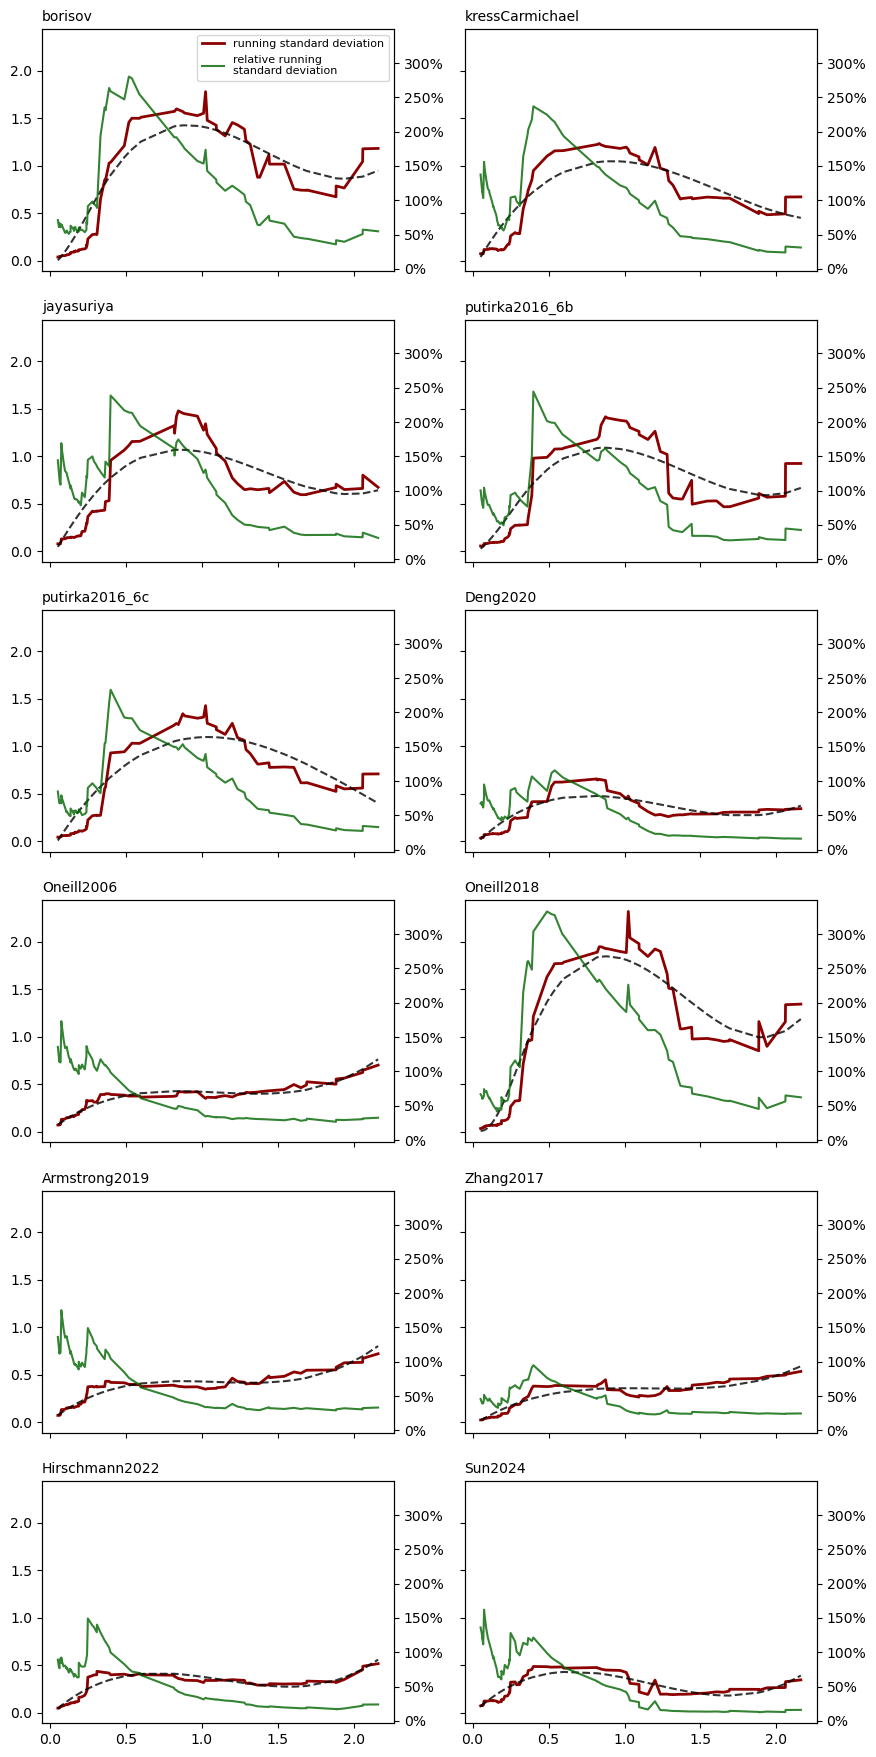

In [114]:
error_params = {}


from matplotlib.ticker import FuncFormatter

pressure_cutoff = 1

fig, axs = plt.subplots(6, 2, figsize=(10,22), sharey=True, sharex=True)

sec_axs = np.empty(shape=axs.shape, dtype=axs.dtype)

for i, (name, d) in enumerate(results.items()):
    
    d_hp = d.query("P_bar > @pressure_cutoff").sort_values("_Fe3Fe2")

    idx = d_hp["_Fe3Fe2_model"].dropna().index
    
    xvals, stddev = _running_stddev(d_hp.loc[idx, "_Fe3Fe2"], d_hp.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    weights = np.ones(len(xvals))
    weights[0]=10
    params = splrep(xvals, stddev, w=weights, s=3)
    # f_results = opt.curve_fit(f=_error_func, xdata=xvals, ydata=stddev, method="lm")
    # error_params[name] = f_results[0]
    
    # axs[i // 2, i % 2].plot(d.query(qry)["_Fe3Fe2"] , d.query(qry)["_Fe3Fe2_model"] , "o", mec="k", markersize=3)
    axs[i // 2, i % 2].plot(xvals, stddev, "-", color="darkred", linewidth=2, label="running standard deviation")
    axs[i // 2, i % 2].plot(xvals, splev(xvals, params), "--", color="k", linewidth=1.5, alpha=0.8)

    sec_axs[i // 2, i % 2] = axs[i // 2, i % 2].twinx()
    sec_axs[i // 2, i % 2].sharey(sec_axs[0, 0])
    sec_axs[i // 2, i % 2].plot(xvals, stddev / xvals, "-", color="darkgreen", linewidth=1.5, alpha=0.8, label="relative running\nstandard deviation")

    axs[i // 2, i % 2].set_title(name, loc="left", size=10)
    sec_axs[i // 2, i % 2].yaxis.set_major_formatter(FuncFormatter(lambda y, _: '{:.0%}'.format(y)))

h1, l1 = axs[0, 0].get_legend_handles_labels()
h2, l2 = sec_axs[0, 0].get_legend_handles_labels()
h = h1 + h2
l = l1 + l2
axs[0,0].legend(h, l, prop={"size": 8})

plt.show()

In [110]:
for i, (name, d) in enumerate(results.items()):
    
    d = d.query("P_bar > 1 & (_Fe3Fe2 < 20)").sort_values("_Fe3Fe2")
    idx = d["_Fe3Fe2_model"].dropna().index

    xvals, stddev = _running_stddev(d.loc[idx, "_Fe3Fe2"], d.loc[idx, "_Fe3Fe2_model"], boxsize=30)
    weights = np.ones(len(xvals))
    weights[0]=10

    print(f"\n{name}:\n{splrep(xvals, stddev, w=weights,s=3)}")


borisov:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.36602451,
       2.16064117, 2.16064117, 2.16064117, 2.16064117]), array([-0.26851486,  0.17700856,  2.82276119,  0.29727467,  0.998269  ,
        0.        ,  0.        ,  0.        ,  0.        ]), 3)

kressCarmichael:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 2.16064117,
       2.16064117, 2.16064117, 2.16064117]), array([-0.15803373,  2.4029921 ,  0.24315807,  0.55458778,  0.        ,
        0.        ,  0.        ,  0.        ]), 3)

jayasuriya:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 2.16064117,
       2.16064117, 2.16064117, 2.16064117]), array([-0.1593344 ,  2.59665428, -0.05032735,  0.73183981,  0.        ,
        0.        ,  0.        ,  0.        ]), 3)

putirka2016_6b:
(array([0.05263158, 0.05263158, 0.05263158, 0.05263158, 0.36602451,
       2.16064117, 2.16064117, 2.16064117, 2.16064117]), array([-0.19827421,  0.15232086,  2.23039298,  0.09093898,  0.71149013,
        0.  